# Time series project

In [66]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [68]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima, ARIMA, model_selection

In [69]:
import warnings
warnings.filterwarnings('ignore')

### Step 1. Reading the data set

In [70]:
# Load data
data = pd.read_csv('Aquifer_Petrignano.csv')

### Step 2. Exploration and data cleaning

In [71]:
# Obtain dimensions
data.shape

(5223, 8)

In [72]:
# Obtain information about data types and non-null values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB
None


In [73]:
# Visualize the NaN values
data.isnull().sum().sort_values(ascending=False)

Rainfall_Bastia_Umbra                   1024
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Hydrometry_Fiume_Chiascio_Petrignano    1024
Volume_C10_Petrignano                    198
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Date                                       0
dtype: int64

In [74]:
data_c=data.copy()
data_c.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [75]:
# Combine the columns with the same features
data_c['Depth_to_Groundwater']=round(((data_c['Depth_to_Groundwater_P24'] + data_c['Depth_to_Groundwater_P25'])/(2)),2)
data_c['Temperature']=round(((data_c['Temperature_Bastia_Umbra'] + data_c['Temperature_Petrignano'])/(2)),2)

In [76]:
# Remove not useful columns
data_c = data_c.drop(columns=['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Temperature_Petrignano'])

In [77]:
# Simplify column names
data_c.columns= ['Date', 'Rainfall', 'Volume',	'Hydrometry',	'Depth_to_Groundwater',	'Temperature']

In [78]:
# Ordering the columns of the DataFrame
data_c=data_c.reindex(['Date', 'Rainfall',	'Temperature', 'Hydrometry', 'Volume', 'Depth_to_Groundwater'], axis=1)
data_c.head()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
0,14/03/2006,NaN,NaN,NaN,NaN,-22.33
1,15/03/2006,NaN,NaN,NaN,NaN,-22.26
2,16/03/2006,NaN,NaN,NaN,NaN,-22.14
3,17/03/2006,NaN,NaN,NaN,NaN,-22.21
4,18/03/2006,NaN,NaN,NaN,NaN,-22.32


In [79]:
# Delete the NaN values from the DataFrame
data_c=data_c.dropna().reset_index(drop=True)
data_c.head()

,Date,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
0,01/01/2009,0.0,5.05,2.4,-24530.688,-31.55
1,02/01/2009,0.0,2.40,2.5,-28785.888,-31.57
2,03/01/2009,0.0,4.15,2.4,-25766.208,-31.52
3,04/01/2009,0.0,0.80,2.4,-27919.296,-31.48
4,05/01/2009,0.0,-2.00,2.3,-29854.656,-31.48


In [80]:
# Changing the format to the 'Date' column
data_c['Date'] = pd.to_datetime(data_c['Date'], format = '%d/%m/%Y')
data_c = data_c.set_index('Date')
data_c.head()

,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
Date,,,,,
2009-01-01,0.0,5.05,2.4,-24530.688,-31.55
2009-01-02,0.0,2.40,2.5,-28785.888,-31.57
2009-01-03,0.0,4.15,2.4,-25766.208,-31.52
2009-01-04,0.0,0.80,2.4,-27919.296,-31.48
2009-01-05,0.0,-2.00,2.3,-29854.656,-31.48


In [81]:
data_c.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4150, freq=None)

In [82]:
# Setting the Frequency
data_c = data_c.asfreq("D")
data_c.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
               '2020-06-25', '2020-06-26', '2020-06-27', '2020-06-28',
               '2020-06-29', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=4199, freq='D')

In [83]:
initial_date = data_c.index[0]
final_date   = data_c.index[-1]
print(f'Initial date: {initial_date}')
print(f'Final date  : {final_date}')

Initial date: 2009-01-01 00:00:00
Final date  : 2020-06-30 00:00:00


In [84]:
data_c['Rainfall'] = data_c['Rainfall'].interpolate(method='linear')
data_c['Temperature'] = data_c['Temperature'].interpolate(method='linear')
data_c['Hydrometry'] = data_c['Hydrometry'].interpolate(method='linear')
data_c['Volume'] = data_c['Volume'].interpolate(method='linear')
data_c['Depth_to_Groundwater'] = data_c['Depth_to_Groundwater'].interpolate(method='linear')

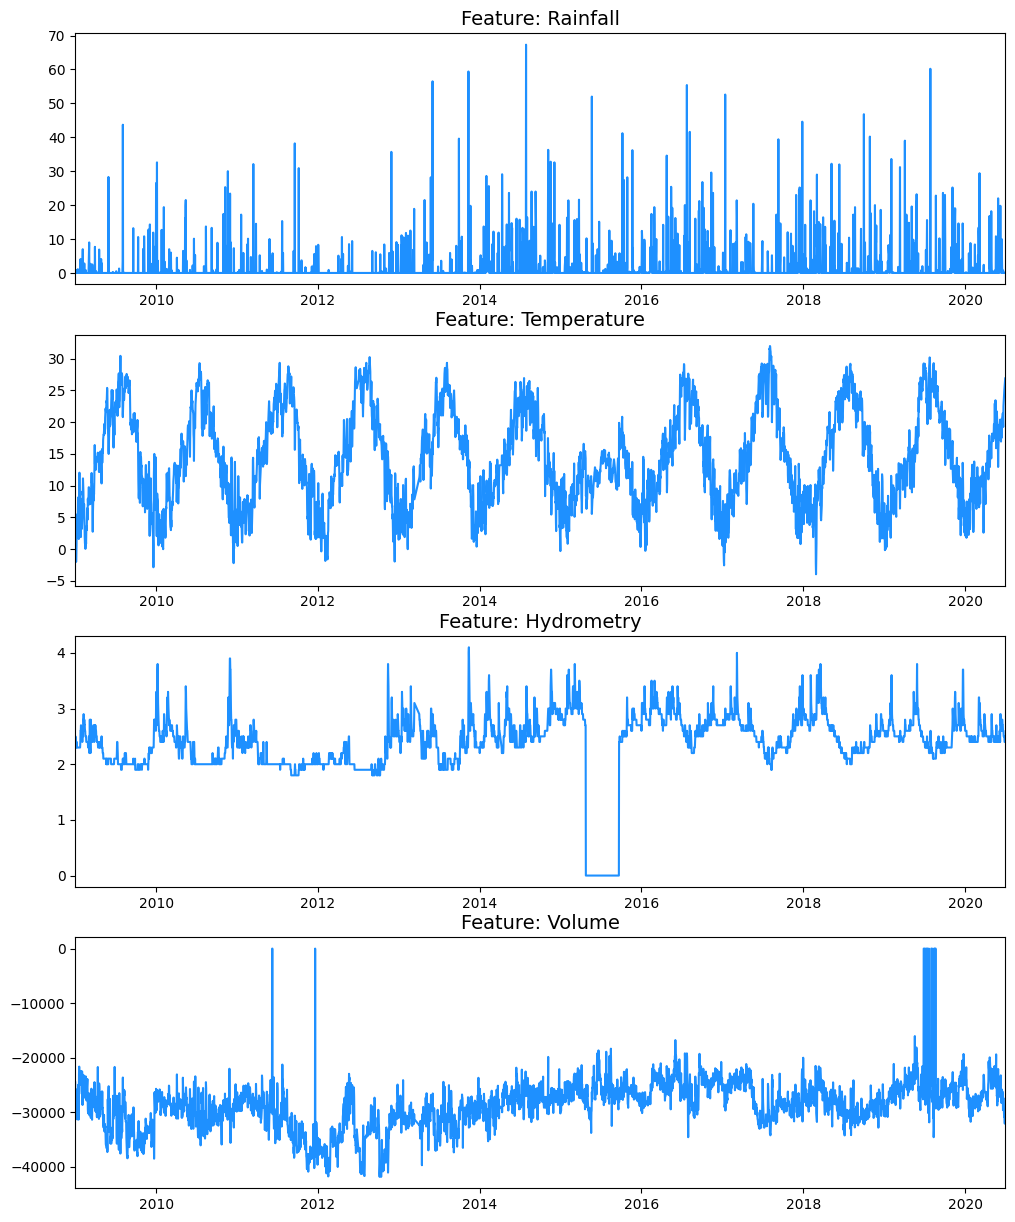

In [85]:
# Data Visualization
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 15))

for i, column in enumerate(data_c.drop('Depth_to_Groundwater', axis=1).columns):
    sns.lineplot(data = data_c[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_xlabel(xlabel=None)
    ax[i].set_ylabel(ylabel=None)
    ax[i].set_xlim(initial_date, final_date)  

### Step 3. Analysis of a time series

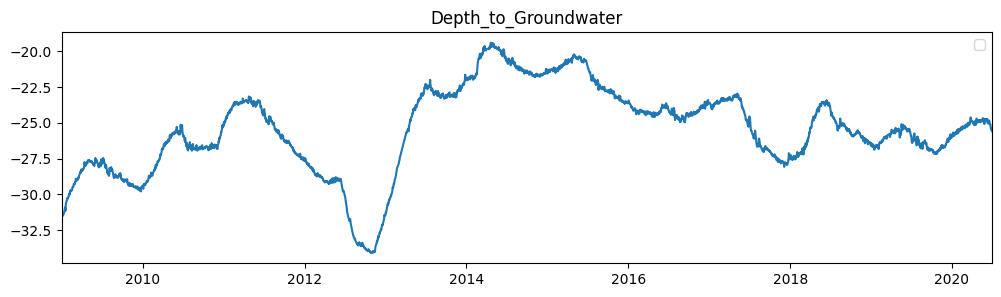

In [86]:
# Plot training and forecast
plt.figure(figsize=(12,3))
plt.plot(data_c['Depth_to_Groundwater'])
plt.title('Depth_to_Groundwater')
plt.xlim(initial_date, final_date)
plt.legend()
plt.show()

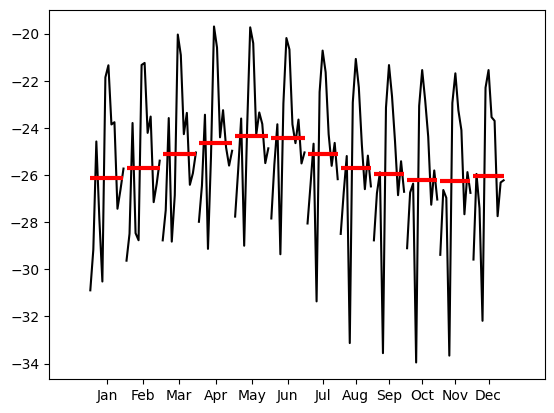

In [87]:
# Plotting the monthly seasonality
month_plot(data_c['Depth_to_Groundwater'].resample('M').mean());

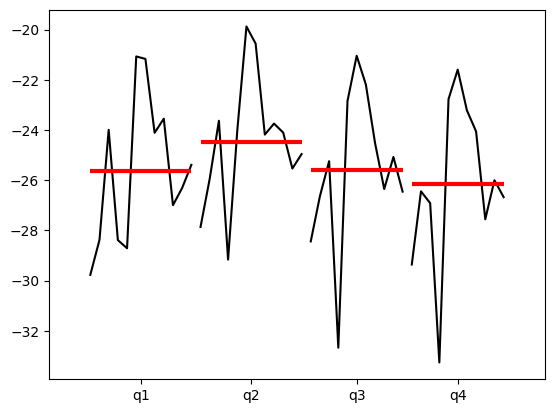

In [88]:
# Plotting the quarterly seasonality
quarter_plot(data_c['Depth_to_Groundwater'].resample('Q').mean());

<function matplotlib.pyplot.show(close=None, block=None)>

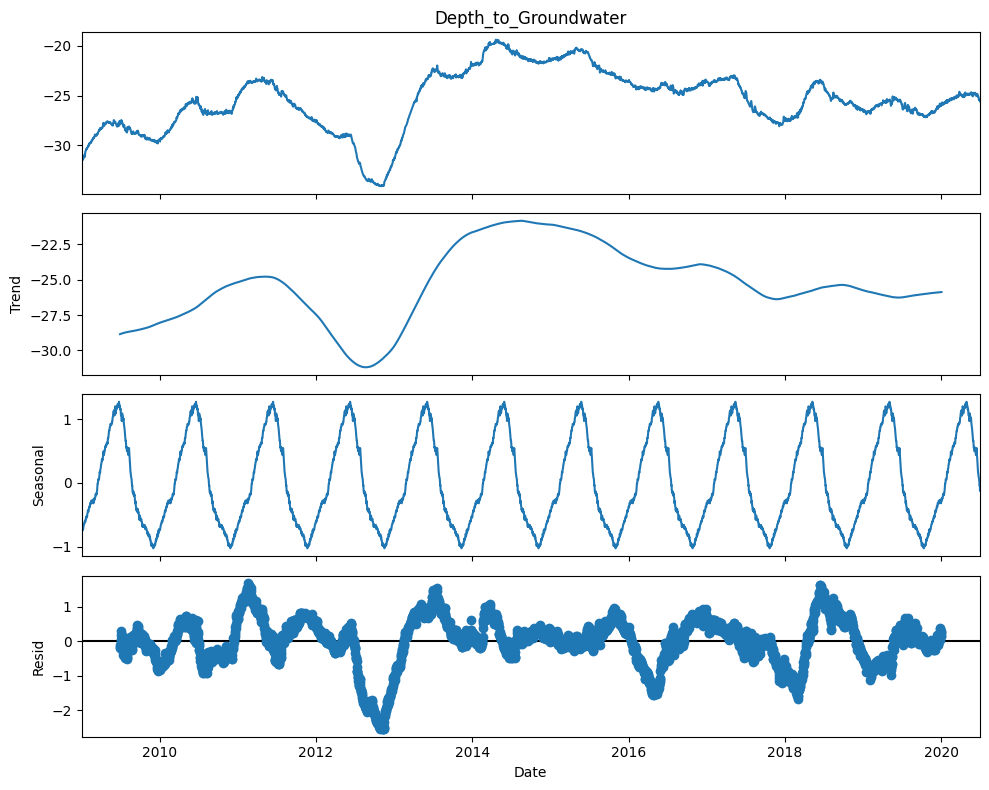

In [89]:
# Time Series Decomposition
decomposition = seasonal_decompose(data_c['Depth_to_Groundwater'], model='add', period = 360) 
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.xlabel("Date")
plt.tight_layout()
plt.show

Autocorrelation analysis

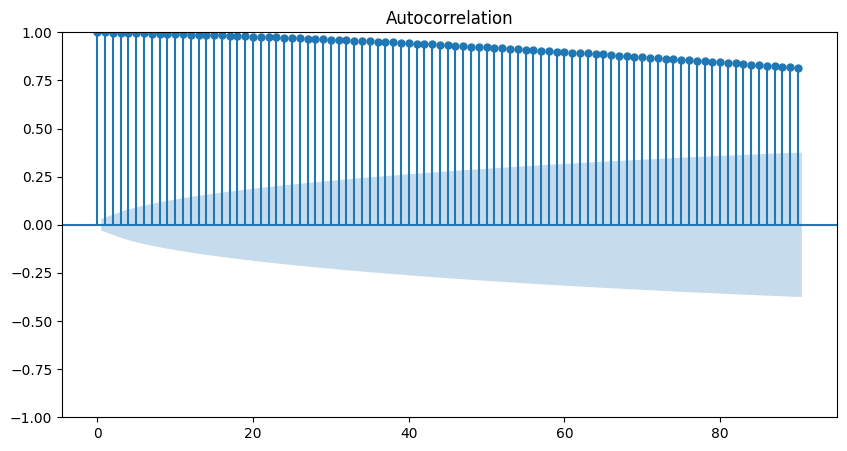

In [90]:
# Plotting the Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_acf(data_c['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

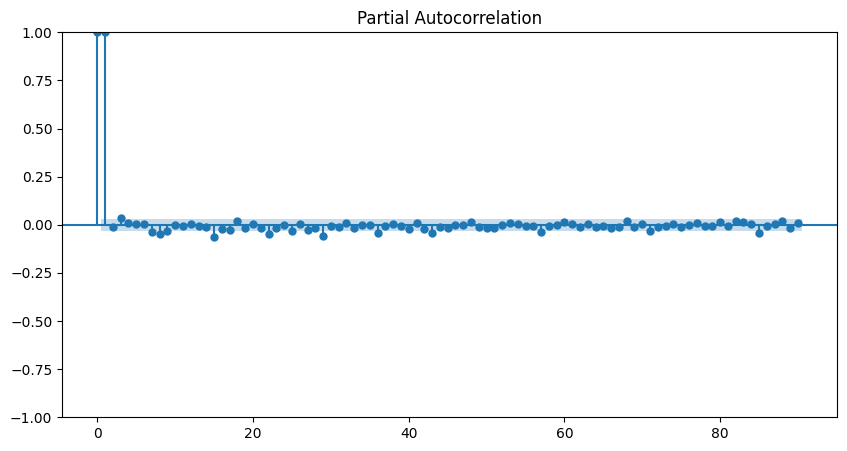

In [91]:
# Plot the Partial Auto-correlation (ACF)
fig, ax = plt.subplots(figsize = (10, 5))
plot_pacf(data_c['Depth_to_Groundwater'], lags = 90, ax = ax)
plt.show()

### Step 4. Model training

In [92]:
# Training and Test Split
periods = 180
train, test = data_c.iloc[:-periods, 4], data_c.iloc[-periods:, 4]

In [93]:
# Holt - Winters Model
model = ExponentialSmoothing(train,
                             trend    = 'add',
                             seasonal = 'add',
                             seasonal_periods = 360).fit()
predictions = model.forecast(steps=len(test))

In [94]:
# Function to assess model and visualize output

def model_assessment(train, test, predictions, chart_title):
  
  # Plot training, test, and forecast
  plt.figure(figsize=(10,4))
  plt.plot(train, label = 'Training')
  plt.plot(test,  label = 'Test')
  plt.plot(predictions, label = 'Forecast')
  plt.title(f'Train, Test and Predictions With {chart_title}')
  plt.legend()
  plt.show()
  
  # Calculating the MAE, RMSE and MAPE
  mae = mean_absolute_error(test, predictions)
  print(f'Mean Absolute Error: {mae:.2f}')
  rmse = mean_squared_error(test, predictions)
  print(f'Root Mean Squared Error: {rmse:.2f}')
  mape = mean_absolute_percentage_error(test, predictions)
  print(f'Mean Absolute Percentage Error: {100*mape:.2f} %')

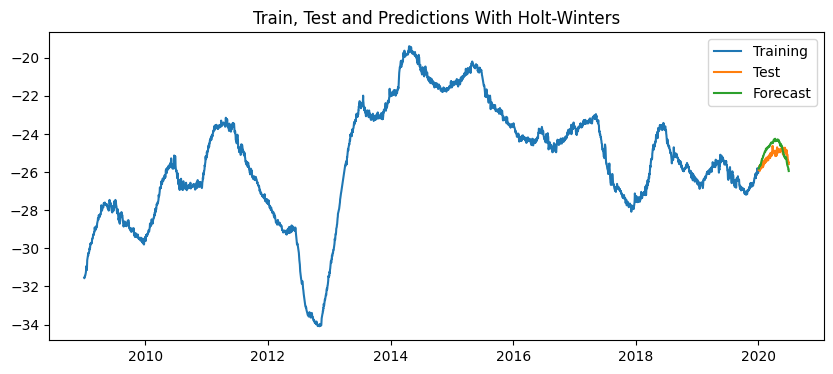

Mean Absolute Error: 0.43
Root Mean Squared Error: 0.22
Mean Absolute Percentage Error: 1.72 %


In [95]:
model_assessment(train, test, predictions, 'Holt-Winters')

### Step 5. Model prediction

In [96]:
# Holt - Winters Model
holt_win_model = ExponentialSmoothing(data_c['Depth_to_Groundwater'],
                             trend    = 'add',
                             seasonal = 'add',
                             seasonal_periods = 360).fit()
forecast = holt_win_model.forecast(steps=360)

In [97]:
# Fuction to plot the future
def plot_future(y, forecast, title):
    # Plot training and forecasts
    plt.figure(figsize=(10,4))
    plt.plot(y, label = 'Training')
    plt.plot(forecast, label = 'Forecast')
    plt.title(f'Train and Forecast With {title}')
    plt.legend()
    plt.show()

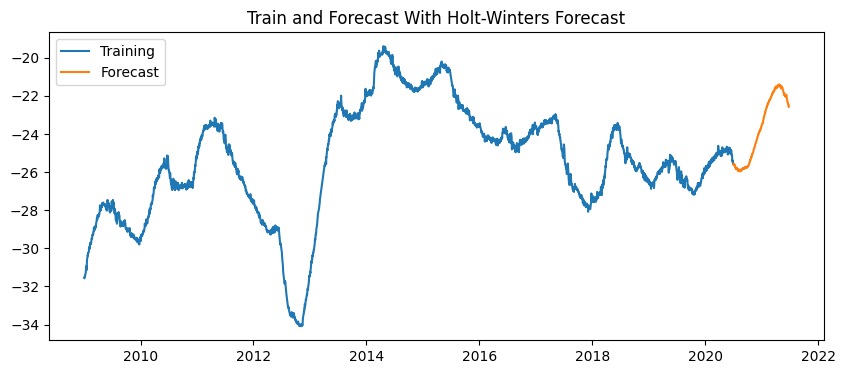

In [98]:
plot_future(data_c['Depth_to_Groundwater'], forecast, 'Holt-Winters Forecast')

ARIMA model

In [99]:
# Perform ADF test

def check_stationary(time_series):
    result = adfuller(time_series)
    print('p-value: ', result[1])
    if result[1]<0.05:
        print("The evidence suggests that the time series is stationary.")
    else:
        print("The evidence suggests that the time series is not estatioanry")

In [100]:
check_stationary(data_c['Depth_to_Groundwater'])

p-value:  0.06820766927021105
The evidence suggests that the time series is not estatioanry


In [101]:
ts_stationary = data_c['Depth_to_Groundwater'].diff().dropna()
check_stationary(ts_stationary)

p-value:  1.1204403407765432e-07
The evidence suggests that the time series is stationary.


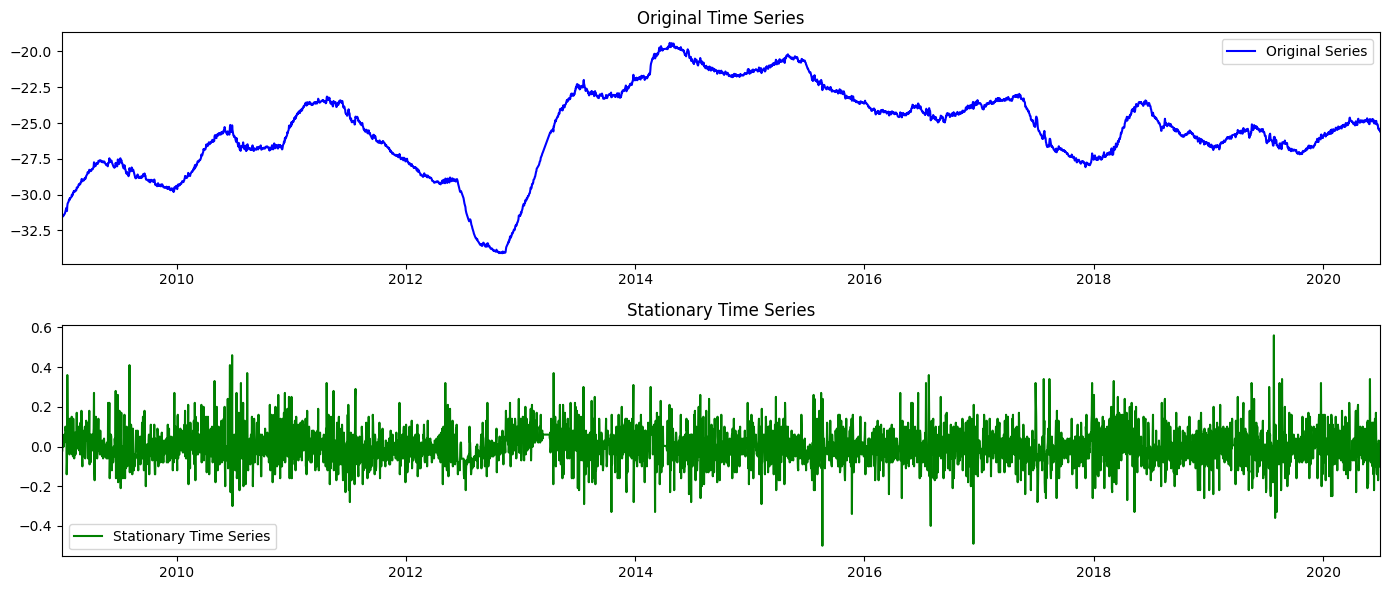

In [102]:
plt.figure(figsize=(14, 6))

# Plotting the original time series and the transformed time series 
        
plt.subplot(2, 1, 1)
plt.plot(data_c['Depth_to_Groundwater'], label='Original Series', color='blue')
plt.title('Original Time Series')
plt.xlim(initial_date, final_date)
plt.legend()

# Subgráfico 2: Serie diferenciada

plt.subplot(2, 1, 2)
plt.plot(ts_stationary, label='Stationary Time Series', color='green')
plt.title('Stationary Time Series')
plt.xlim(initial_date, final_date)
plt.legend()

plt.tight_layout()
plt.show()

In [103]:
# Training and Test Split
periods = 30
train, test = data_c.iloc[:-periods, 4], data_c.iloc[-periods:, 4]

In [104]:
# Using pmdarima for the arima model and the best parameters
arima_model = auto_arima(train, seasonal = False
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-daily, 12-monthly, 52-weekly
                        #seasonal=False,
                        #d=None,
                        #trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

In [105]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4169
Model:               SARIMAX(0, 1, 2)   Log Likelihood                4098.713
Date:                Tue, 20 May 2025   AIC                          -8191.425
Time:                        05:49:00   BIC                          -8172.420
Sample:                    01-01-2009   HQIC                         -8184.702
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0199      0.013      1.541      0.123      -0.005       0.045
ma.L2         -0.0634      0.015     -4.348      0.000      -0.092      -0.035
sigma2         0.0082      0.000     65.726      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               874.23
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
# Predictions
arima_predictions = arima_model.predict(n_periods = len(test))

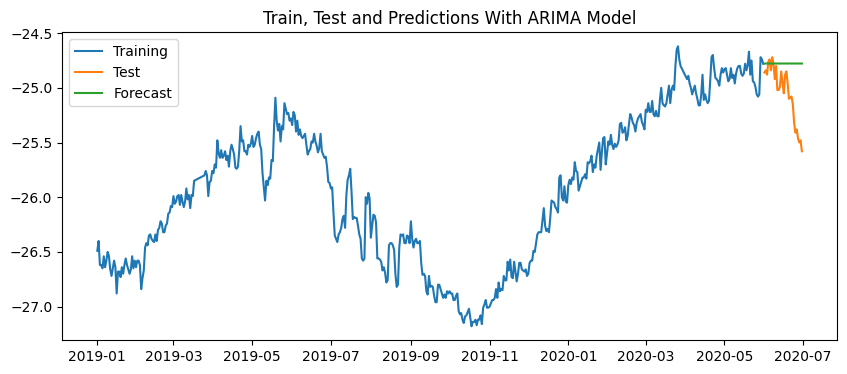

Mean Absolute Error: 0.27
Root Mean Squared Error: 0.13
Mean Absolute Percentage Error: 1.08 %


In [107]:
model_assessment(train['2019':], test, arima_predictions, "ARIMA Model")

SARIMA Model

In [108]:
# Using pmdarima for the sarima model and the best parameters
sarima_model = auto_arima(train, seasonal = True, trace = True
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-daily, 12-monthly, 52-weekly
                        #seasonal=False,
                        #d=None,
                        #trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8188.385, Time=2.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8175.986, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8175.577, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8175.811, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8176.650, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8189.702, Time=1.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8190.901, Time=0.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8189.896, Time=1.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8179.488, Time=2.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8187.892, Time=2.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8191.425, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8176.533, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8190.197, Time=1.30 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-8190.385, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0

In [109]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4169
Model:               SARIMAX(0, 1, 2)   Log Likelihood                4098.713
Date:                Tue, 20 May 2025   AIC                          -8191.425
Time:                        05:49:17   BIC                          -8172.420
Sample:                    01-01-2009   HQIC                         -8184.702
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0199      0.013      1.541      0.123      -0.005       0.045
ma.L2         -0.0634      0.015     -4.348      0.000      -0.092      -0.035
sigma2         0.0082      0.000     65.726      0.000       0.008       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               874.23
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
# Predictions
sarima_predictions = sarima_model.predict(n_periods = len(test))

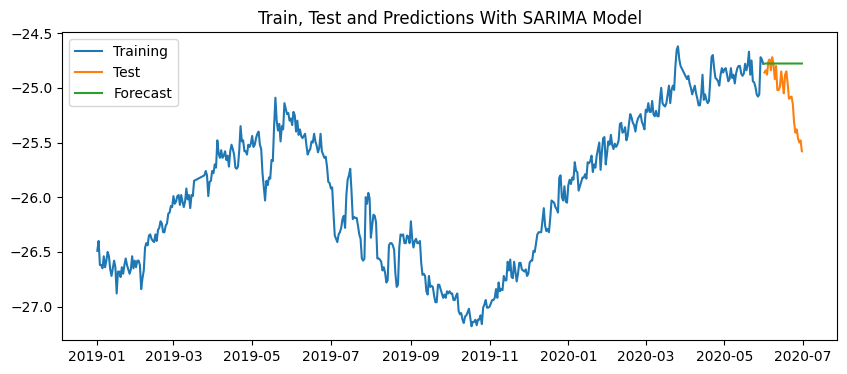

Mean Absolute Error: 0.27
Root Mean Squared Error: 0.13
Mean Absolute Percentage Error: 1.08 %


In [111]:
model_assessment(train['2019':], test, sarima_predictions, "SARIMA Model")

SARIMAX Model

In [112]:
data_c.head()

,Rainfall,Temperature,Hydrometry,Volume,Depth_to_Groundwater
Date,,,,,
2009-01-01,0.0,5.05,2.4,-24530.688,-31.55
2009-01-02,0.0,2.40,2.5,-28785.888,-31.57
2009-01-03,0.0,4.15,2.4,-25766.208,-31.52
2009-01-04,0.0,0.80,2.4,-27919.296,-31.48
2009-01-05,0.0,-2.00,2.3,-29854.656,-31.48


In [113]:
# Split the Regressor Data into train and test
exog_train, exog_test = data_c.iloc[:-periods, 0:4], data_c.iloc[-periods:, 0:4]

In [114]:
# Using pmdarima for the arima model and the best parameters
sarimax_model = auto_arima(train, X=exog_train
                        #start_p=0, start_q=0,
                        #max_p=5, maxq=5,
                        #m=7, #7-daily, 12-monthly, 52-weekly
                        #seasonal=False,
                        #d=None,
                        #trace=True,
                        #error_action='ignore',
                        #suppress_warnings=True,
                        #stepwise=True
                        )

In [115]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4169
Model:               SARIMAX(0, 1, 1)   Log Likelihood                4634.111
Date:                Tue, 20 May 2025   AIC                          -9256.222
Time:                        05:50:40   BIC                          -9218.211
Sample:                    01-01-2009   HQIC                         -9242.776
                         - 05-31-2020                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Rainfall        0.0014      0.000     11.178      0.000       0.001       0.002
Temperature     0.0031      0.001      5.040      0.000       0.002       0.004
Hydrometry      0.0191      0.010      1.876      0.061      -0.001       0.039
Volume       1.545e-05   1.56e-07     99.069      0.000    1.51e-05    1.58e-05
ma.L1           0.0268      0.009      2.967      0.003       0.009       0.044
sigma2          0.0063   9.15e-05     69.283      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12334.62
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
# Predictions
sarimax_predictions = sarimax_model.predict(n_periods = len(test), X=exog_test)

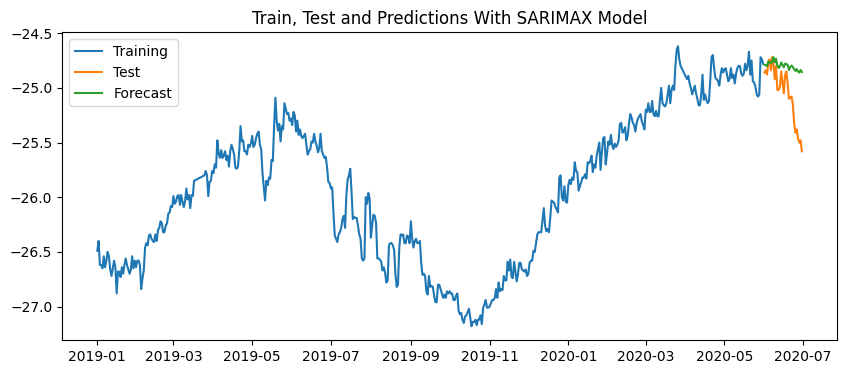

Mean Absolute Error: 0.25
Root Mean Squared Error: 0.11
Mean Absolute Percentage Error: 0.98 %


In [117]:
model_assessment(train['2019':], test, sarimax_predictions, "SARIMAX Model")